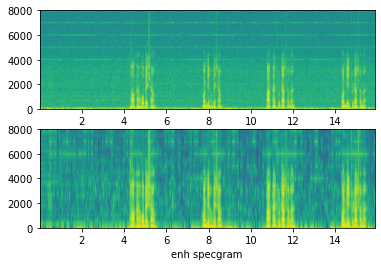

In [4]:
import librosa
from librosa.util import frame
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz


# 构建多窗口函数
def sine_taper(L, N):
    tapers= np.zeros( [N, L]);
    index = np.array([i+1  for i in range(N)])
    for i in range(L):
        tapers[:,i] = np.sqrt(2/(N+1))* np.sin(np.pi * (i+1)*index/(N+1))
    
    return tapers

# x 输入信号长度为N
# p 估计的协方差矩阵的大小  p<<N
# W 一组窗口函数 大小为 N x L
def estimate_R(x,p,W):
    
    N,L = np.shape(W)
    x_rep = np.tile(x,[L,1]) #  L x N
    x_rep = x_rep.T          # N x L
    
    # 对信号进行加窗处理
    x_w= W* x_rep
    
    # 矩阵相乘
    R1= np.dot(x_w, x_w.T)
   
    r = np.zeros(p)
    for i in range(p):
        r[i] = np.sum(np.diag(R1,k=i))
    
    R_est = toeplitz(r)
    return R_est

# 信号重构    
def frame2singal(frames):
    N,d = np.shape(frames)
    
    half_frame = int(d/2)
    overlap = np.zeros(half_frame)
    len_singal = d +(N-1)*(half_frame)
    start =0
    singal = np.zeros(len_singal)
    for i in range(N):
        temp = frames[i]
        singal[start:start+half_frame] = temp[:half_frame] + overlap
        overlap = temp[half_frame:]
        start = start +half_frame
    singal[start:] = overlap
    return singal


L=16  # 多窗口法进行Rx估计时窗口的数据  
vad_thre= 1.2  # 是否进行Rn 更新的阈值
mu_vad= 0.98   # Rn 更新参数

mu_max=5  # mu的最大值
mu_toplus= 1 # mu的最小值
# 估计mu 时使用的参数
mu_tominus= mu_max;  
mu_slope= (mu_tominus- mu_toplus )/ 25
mu0= mu_toplus+ 20* mu_slope

# 读取原始 
noisy_wav_file = "spec_sub_demo.wav"
noisy_speech,fs = librosa.load(noisy_wav_file,sr=None)


subframe_dur= 4  #子帧的时长为4ms
len_subframe= int(np.floor( fs* subframe_dur/ 1000))

P= len_subframe # 协防差矩阵的大小 P*P

frame_dur= 32  # 帧的时长
len_frame = int(np.floor(frame_dur* fs/ 1000)) 

len_step_frame= int(len_frame/ 2)  #帧移 

# 帧 和 子帧的窗函数
window_frame = np.hamming(len_frame)
window_subframe= np.hamming(len_subframe) 

# 进行噪声协方差矩阵的估计
# 假设前120ms是噪声
noise_dur = 120 
N_noise=int(np.floor( noise_dur* fs/ 1000))
noise= noisy_speech[:N_noise]

# 获取一组窗函数
tapers= sine_taper( L, N_noise)
# 进行噪声的协方差矩阵估计
Rn = estimate_R(noise,P,tapers)
iRn = np.linalg.inv(Rn)



# 对噪声信号进行分帧
noisy_frames = frame(noisy_speech, frame_length=len_frame, hop_length=len_step_frame,axis = 0 )
# 获取帧数
N_frame = noisy_frames.shape[0]

# 获取用来进行Ry估计的tapers
tapers_noisy = sine_taper( L, len_frame)

# 存储增强后的语音帧
enh_frames = np.zeros(np.shape(noisy_frames))

# 逐帧处理
for n in range(N_frame):
  
    # 读取一帧数据
    noisy = noisy_frames[n]

    # 进行协方差矩阵 Ry 估计
    Ry = estimate_R(noisy,P,tapers_noisy)
   
    # 利用 VAD 进行 Rn 的更新
    vad_ratio= Ry[0,0]/ Rn[0,0]
    if vad_ratio<= vad_thre: 
        Rn= mu_vad* Rn+ (1- mu_vad)* Ry
        iRn= np.linalg.inv( Rn)

    # 计算iRnRx
    In= np.eye(P)   
    iRnRx= np.dot(iRn, Ry)- In
    
    # 获取 特征向量 V与对角线特征值矩阵 D
    d, V = np.linalg.eig(iRnRx)  
    iV= np.linalg.inv(V)
    
    # 进行信噪比估计  将特征值小于0 的部分置 0
    # 用来估计 delta_X
    d[d<0]=0
    dRx = d
    
    # 根据信噪比计算 mu  
    SNR  = np.sum(dRx)/P
    SNR_db = 10 * np.log10( SNR+ 1e-10)
    if SNR_db >= 20:
        mu = mu_toplus    
    elif SNR_db< 20  and SNR_db>= -5 :
        mu = mu0- SNR_db * mu_slope
    else:
        mu = mu_tominus
      
    # 计算增益系数
    gain_vals= dRx/( dRx+mu) 
    G= np.diag( gain_vals)
    
    # 获得映射矩阵
    H = np.dot(np.dot(iV.T,G),V.T)
   
    # 对frame 进行分帧
    sub_frames = frame(noisy, frame_length=len_subframe, hop_length=int(len_subframe/2), axis = 0)  # N * d
    # 逐帧 sub_frames 进行增强
    enh_sub_frames = np.dot(sub_frames,H.T) # N x d
    # 加窗
    enh_sub_frames = enh_sub_frames * window_subframe
    # 信号恢复
    enh_signal = frame2singal(enh_sub_frames)
    enh_frames[n] = enh_signal

# 对增强帧进行加窗
enh_frames = enh_frames*window_frame
enh_wav = frame2singal(enh_frames)


sf.write("subspace_enh.wav",enh_wav,fs)
        
    
plt.subplot(2,1,1)
plt.specgram(noisy_speech,NFFT=256,Fs=fs)
plt.xlabel("noisy specgram")
plt.subplot(2,1,2)
plt.specgram(enh_wav,NFFT=256,Fs=fs)
plt.xlabel("enh specgram")   
plt.show()
    